Cloning into 'WIE3007-GroupProject-Sem1-2025'...
remote: Enumerating objects: 200, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 200 (delta 47), reused 29 (delta 29), pack-reused 137 (from 1)
Receiving objects: 100% (200/200), 4.15 MiB | 42.09 MiB/s, done.
Resolving deltas: 100% (104/104), done.


Load the Data

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score


In [ ]:
# Load features and target from the local repository
X = pd.read_csv("../data/features.csv")
y = pd.read_csv("../data/target.csv").squeeze()

# LEAKAGE PREVENTION
# 'days_since_last_purchase' is dropped to force the model to learn from other signals.
features_to_drop = ['days_since_last_purchase']
X = X.drop(columns=[col for col in features_to_drop if col in X.columns])
print(f"DROPPED LEAKAGE FEATURES: {features_to_drop}")

# Validation Check
print(f"Features Shape: {X.shape}")
print(f"Target Shape: {y.shape}")
X.head()

DROPPED LEAKAGE FEATURES: ['days_since_last_purchase']
Features Shape: (1200, 8)
Target Shape: (1200,)


,age,income,total_orders,avg_order_value,estimated_spend,spend_ratio,sentiment_score,risk_score
0,58,74592,22,133.88,2945.36,0.039486,1,1
1,61,131482,42,161.12,6767.04,0.051467,2,0
2,50,138907,50,219.59,10979.50,0.079042,2,0
3,44,64446,22,258.07,5677.54,0.088098,0,2
4,62,115392,32,204.42,6541.44,0.056689,0,2


Train/Test Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Train Size: {X_train.shape[0]}")
print(f"Test Size: {X_test.shape[0]}")


Train Size: 960
Test Size: 240


In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train the MLP (Neural Network) Model

In [17]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(
    hidden_layer_sizes=(100, 50, 25),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42
)

model.fit(X_train_scaled, y_train)

MLPClassifier(hidden_layer_sizes=(100, 50, 25), max_iter=1000, random_state=42)

In [18]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC:  {roc_auc_score(y_test, y_prob):.4f}")

Accuracy: 0.9292
F1-Score: 0.9017
ROC-AUC:  0.9618


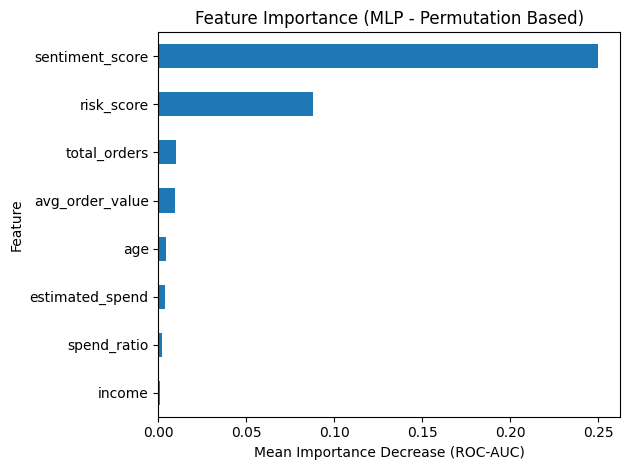

sentiment_score    0.249924
risk_score         0.087904
total_orders       0.010211
avg_order_value    0.009512
age                0.004129
estimated_spend    0.003518
spend_ratio        0.002297
income             0.001091
dtype: float64


In [19]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

# Compute permutation importance using ROC-AUC as the metric
perm_importance = permutation_importance(
    model,
    X_test_scaled,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring="roc_auc"
)

# Convert to Series
mlp_importance = pd.Series(
    perm_importance.importances_mean,
    index=X.columns
).sort_values(ascending=False)

# Top 10 features
top10 = mlp_importance.head(10)

# Plot
top10.sort_values().plot(kind="barh")
plt.title("Feature Importance (MLP - Permutation Based)")
plt.xlabel("Mean Importance Decrease (ROC-AUC)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Print values
print(top10)


In [20]:
results = {
    "model": "MLP (Neural Network)",
    "accuracy": accuracy_score(y_test, y_pred),
    "f1_score": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_prob)
}

pd.DataFrame([results])


,model,accuracy,f1_score,roc_auc
0,MLP (Neural Network),0.929167,0.901734,0.961767


**Documentation**

MLP (Neural Network) Model

An MLP (Multi-Layer Perceptron) classifier was implemented to evaluate the effectiveness of a neural network approach for customer churn prediction on structured tabular data. The model achieved strong performance across all evaluation metrics, demonstrating its ability to learn non-linear decision boundaries within the engineered feature space.

Interpretation:
The MLP model attained high Accuracy, F1-score, and ROC-AUC values, indicating successful learning despite the presence of probabilistic churn noise and injected “Karen” customer behavior. However, feature importance analysis revealed a heavy reliance on sentiment-related features, with comparatively weaker contributions from demographic and economic variables. This suggests that while the neural network is capable of capturing non-linear patterns, it lacks the interpretability and feature interaction transparency provided by tree-based models such as Random Forest and XGBoost. As a result, the MLP performs competitively but does not offer a clear advantage over ensemble methods for this tabular dataset.